In [1]:
!pip install -r requirements.txt

In [12]:

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

In [3]:
df=pd.read_csv('processed/ChurnModeling_Binning_Applied.csv')

In [4]:
df.head()

,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreBins
0,France,Female,42.00,2,0.00,1,1,1,101348.88,1,Fair
1,Spain,Female,41.00,1,83807.86,1,0,1,112542.58,0,Fair
2,France,Female,42.00,8,159660.80,3,1,0,113931.57,1,Poor
3,France,Female,38.91,1,0.00,2,0,0,93826.63,0,Good
4,Spain,Female,43.00,2,125510.82,1,1,1,79084.10,0,Excellent


Build Sklearn Pipeline

In [5]:
from math import remainder


remainder_features = ['NumOfProducts','HasCrCard','IsActiveMember','Exited']
numerical_features = ['Age','Tenure','Balance','EstimatedSalary']
nominal_features = ['Gender','Geography']
ordinal_features = ['CreditScoreBins']

numerical_transformer = Pipeline(
                                steps = [
                                    ('imputer',SimpleImputer(strategy='median')),
                                    ('scalar',StandardScaler())
                                ]


                                )

nominal_transformer = Pipeline(
                                steps = [

                                    ('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
                                    ('scalar',OneHotEncoder())
                                ]


                            )

ordinal_transformer = Pipeline(

                                steps = [

                                    ('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
                                    ('scalar',OrdinalEncoder())
                                ]

)



#now we have to merge all these pipelines create a one single pipeline
preprocessor = ColumnTransformer(
                                transformers = [
                                    ('num',numerical_transformer,numerical_features),
                                    ('nom',nominal_transformer,nominal_features),
                                    ('ord',ordinal_transformer,ordinal_features)

                                ],
                                remainder = 'drop'
                                )

nominal_feature_names = []
for feature in nominal_features:
    unique_values = df[feature].unique()
    nominal_feature_names.extend([f"{feature}_{val}" for val in unique_values])

df_cp = df.copy()  #good practice
df_transformed = pd.DataFrame(
                    preprocessor.fit_transform(df_cp),
                    columns=numerical_features+nominal_feature_names+ordinal_features
                )
df_reminder = df[remainder_features]
df_pp = pd.concat([df_transformed,df_reminder],axis=1)
df_pp

,Age,Tenure,Balance,EstimatedSalary,Gender_Female,Gender_Male,Geography_France,Geography_Spain,Geography_Germany,CreditScoreBins,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,0.302983,-1.041760,-1.225848,0.021886,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1,1
1,0.204867,-1.387538,0.117350,0.216534,1.0,0.0,0.0,0.0,1.0,1.0,1,0,1,0
2,0.302983,1.032908,1.333053,0.240687,1.0,0.0,1.0,0.0,0.0,3.0,3,1,0,1
3,-0.000196,-1.387538,-1.225848,-0.108918,1.0,0.0,1.0,0.0,0.0,2.0,2,0,0,0
4,0.401100,-1.041760,0.785728,-0.365276,1.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.008634,-0.004426,-1.225848,-0.066419,0.0,1.0,1.0,0.0,0.0,4.0,2,1,0,0
9996,-0.383831,1.724464,-0.306379,0.027988,0.0,1.0,1.0,0.0,0.0,3.0,1,1,1,0
9997,-0.285715,0.687130,-1.225848,-1.008643,1.0,0.0,1.0,0.0,0.0,2.0,1,0,1,1
9998,0.302983,-0.695982,-0.022608,-0.125231,0.0,1.0,0.0,1.0,0.0,4.0,2,1,0,1


In [6]:
df_pp.to_csv('processed/ChurnModeling_X_Transformed.csv',index=False)

Handle class Imbalance

In [8]:
x=df_pp.drop(columns=['Exited'])
y=df_pp['Exited']

consider  below example to get an understanding on upsampling and downsamplin

churn => 1000
nonchurn => 9000

in upsamplin we make (churn)1000 -> 9000 by randomly
in down sampling we make (non-churn)9000 -> 1000

In [9]:
from pandas.core.common import random_state


x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [11]:
smote = SMOTE(random_state=42)
x_train_resampled,y_train_resampled =smote.fit_resample(x_train,y_train)

Text(0, 0.5, 'Count')

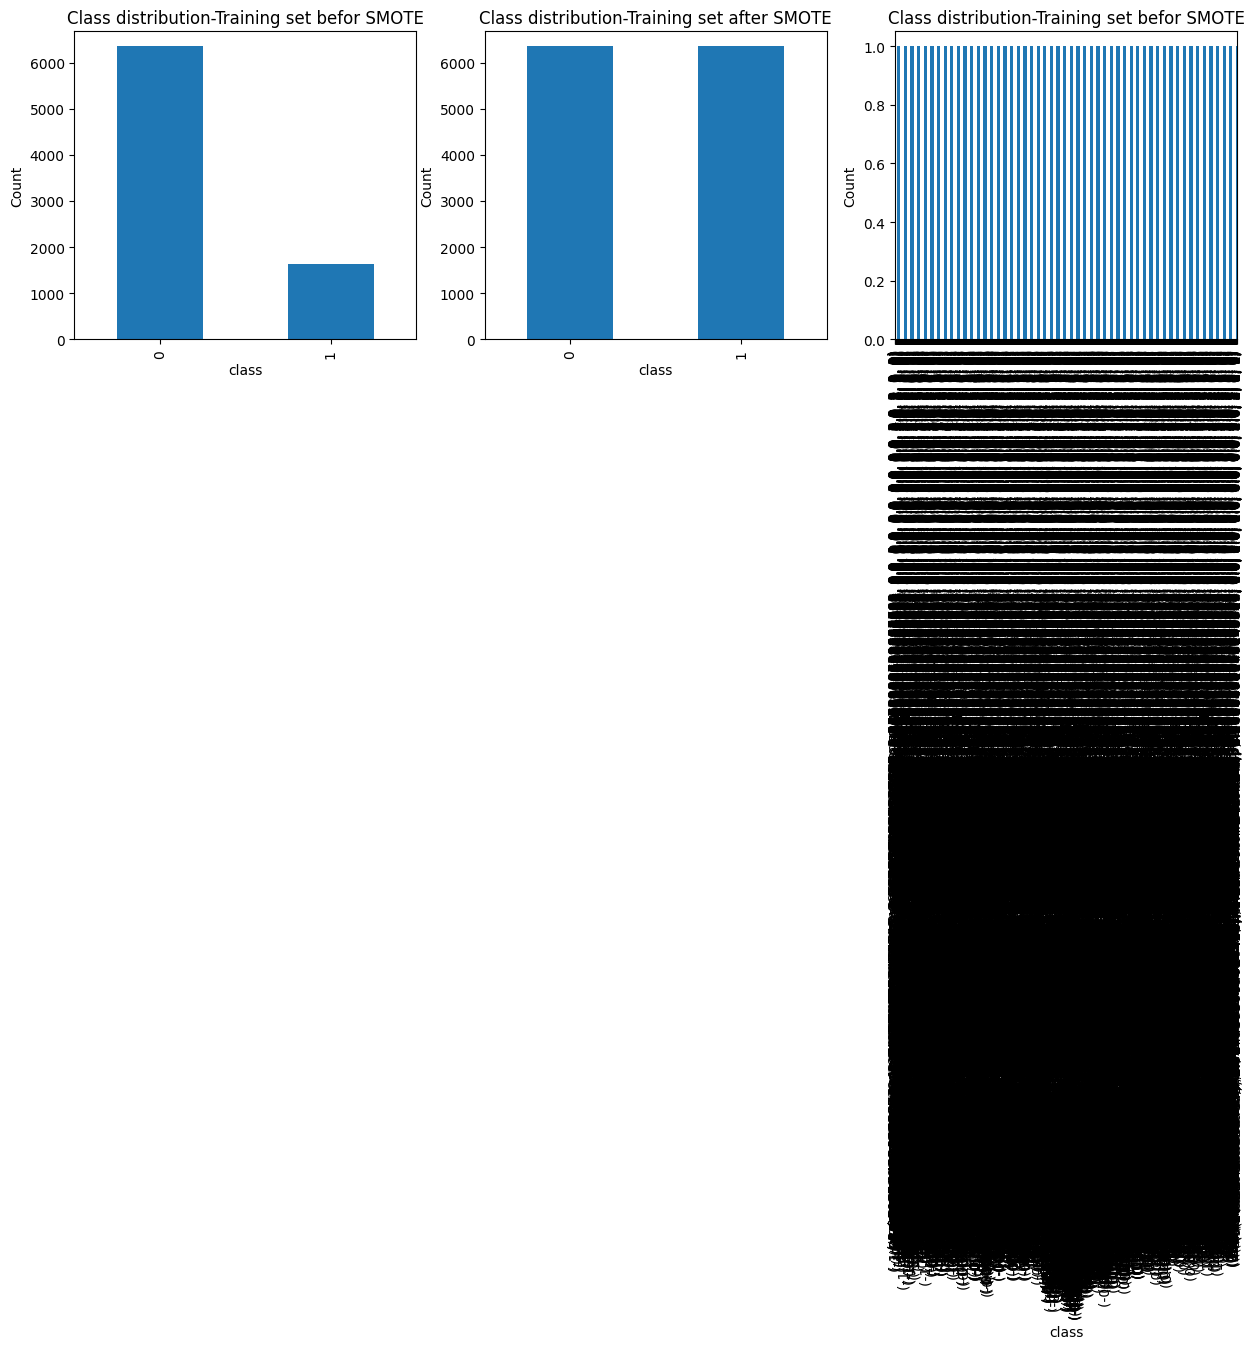

In [16]:
plt.figure(figsize=(15,4))

#Before SMOTE
plt.subplot(131)
y_train.value_counts().plot(kind='bar')
plt.title("Class distribution-Training set befor SMOTE")
plt.xlabel('class')
plt.ylabel('Count')

#after SmMOTE
plt.subplot(132)
y_train_resampled.value_counts().plot(kind='bar')
plt.title("Class distribution-Training set after SMOTE")
plt.xlabel('class')
plt.ylabel('Count')

plt.subplot(133)
x_test.value_counts().plot(kind='bar')
plt.title("Class distribution-Training set befor SMOTE")
plt.xlabel('class')
plt.ylabel('Count')



In [19]:
np.savez('../artifacts/x_train.npz',x_train_resampled)
np.savez('../artifacts/y_train.npz',y_train_resampled)
np.savez('../artifacts/x_test.npz',x_test)
np.savez('../artifacts/y_test.npz',y_test)